In [1]:
!pip install wordcloud
!pip install textblob
!pip install cufflinks
!pip install imblearn

In [4]:
import pandas as pd 
import numpy as np 
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

## Importing the dataset


In [59]:
raw_reviews = pd.read_csv('Musical_instruments_review.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [6]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

## Dataset Details


**This dataset contains the following columns:**

* reviewerID: The unique identifier of the reviewer, for example, A2SUAM1J3GNN3B.
* asin: The unique identifier of the product, for example, 0000013714.
* reviewerName: The name of the reviewer.
* helpful: The rating of how helpful the review was, for example, 2/3.
* reviewText: The content of the review provided by the reviewer.
* overall: The rating of the product on a scale of 1 to 5.
* summary: A concise summary of the review.
* unixReviewTime: The time of the review in Unix time format.
* reviewTime: The time of the review in raw format.

<a id="section-two"></a>
## Preprocessing and cleaning

**We got to do lot of preprocessing before sending the reviews to the model.**

### Handling NaN values



In [7]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

**We've identified null values in reviewer names and review text. Since reviewer names don't contribute to our project objectives (as we have IDs instead), our attention is directed towards the review text. While dropping null values, which are only 7 in number, seems reasonable, we're considering imputing them as missing data. We aim to investigate why these reviewers didn't leave any text. Could it be related to their ratings?**

In [8]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

## Merging Review Text and Summary

We'll merge the content from the review text and summary columns. Since both convey sentiments about the product, there shouldn't be any conflicting information. 

In [9]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

## Generating 'Sentiment' Column

In this crucial preprocessing step, we're determining the sentiment of each review based on the overall rating. Reviews with a score greater than 3 will be categorized as positive, those with a score less than 3 will be labeled as negative, and reviews with a score equal to 3 will be considered neutral sentiment.

In [10]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [11]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [12]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [13]:
process_reviews['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

## Processing the Time Column

The time column in our dataset appears to be in an unusual format, containing both the date and year information. Our approach involves splitting this column into date and year components. Subsequently, we'll further split the date into month and day components.

In [14]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   date   year  
0  Positive  02 28   2014  
1  Positive  03 16   2013  
2  Positive  08 28   2013  
3  Positive  02 14   2014  
4  Positive  02 21   2014

In [15]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   year month day  
0  Positive   2014    02  28  
1  Positive   2013    03  16  
2  Positive   2013    08  28  
3  Positive   2014    02  14  
4  Positive   2014    02  21

## Finding the helpfulness of the review


In [16]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)


# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)

In [17]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment   year month  \
0  Not much to write about here, but it does exac...  Positive   2014    02   
1  The product does exactly as it should and is q...  Positive   2013    03   
2  The primary job of this device is to block the...  Positive   2013    08   
3  Nice windscreen protects my MXL mic and preven...  Positive   2014    02   
4  This pop filter is great. It looks and perform...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

**We have successfully created the helpful_rate column through processing steps.**

In [18]:
process_reviews['helpful_rate'].value_counts()

0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: helpful_rate, Length: 65, dtype: int64

**0.00 indicates that the review hasn't been much helpful and 1.00 indicates that the review has been very helpful**

## Review text-Punctuation Cleaning


In [19]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [20]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [21]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much to write about here but it does exact...  Positive   2014    02   
1  the product does exactly as it should and is q...  Positive   2013    03   
2  the primary job of this device is to block the...  Positive   2013    08   
3  nice windscreen protects my mxl mic and preven...  Positive   2014    02   
4  this pop filter is great it looks and performs...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

**We have removed all punctuation in our review column**

## Handling Stop Words in Review Text

When it comes to stop words, the conventional NLTK stop word list includes words like "not," "hasn't," and "wouldn't," which actually convey negative sentiment. Removing these words may contradict the target variable (sentiment). Therefore, I've curated a custom stop word list that excludes words with negative sentiment or any negative alternatives. This ensures that the stop words removal process doesn't interfere with the sentiment analysis task.

In [22]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [23]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

We have removed all the stop words in the review column

<a id="section-three"></a>
# Narrative Construction and Visualization from Reviews

**In this segment, we will conduct exploratory data analysis on textual data along with other factors to discern which features influence sentiment.**

**Pre-analysis Assumptions:**
* Reviews with a higher helpful rate tend to exhibit a positive sentiment.
* A notable portion of negative sentiment reviews is expected in the years 2013 and 2014.
* The beginning of a month is anticipated to have a higher volume of reviews.

**We will validate these assumptions through our visualizations, coupled with extensive text analysis.**

## Sentiments vs Helpful rate
**First lets look whether there any relationship between sentiment of review and helpfulness of it**

In [24]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

helpful_rate
sentiment              
Negative       0.307559
Neutral        0.275687
Positive       0.260505

**From the table we can see that the mean of of helpful rate is higher for any negative reviews than neutral and positive reviews. These mean value might have been influenced by the 0 values in helpful rates. Lets check how it is distributed through violin plot**

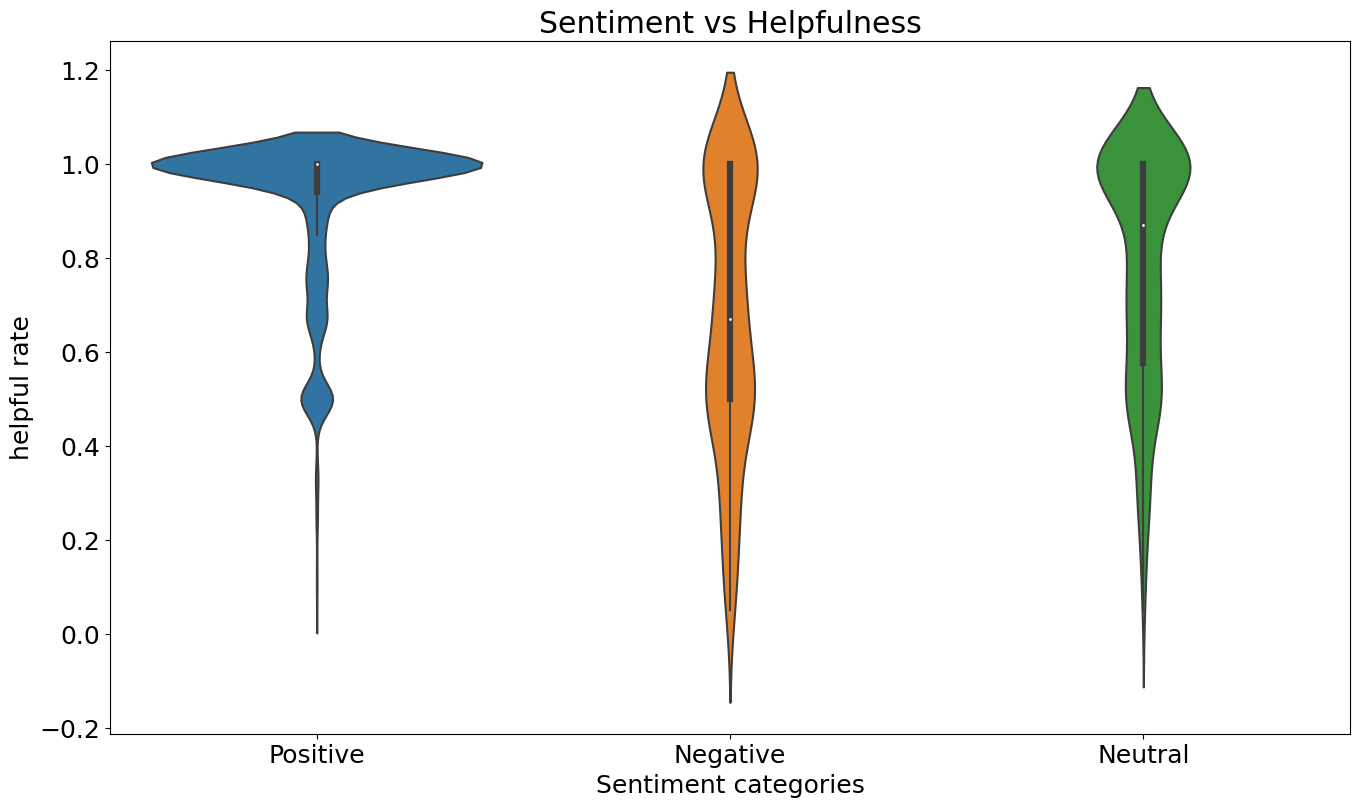

In [25]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

**Insights:** <br>

**From the plot we can declare that more number of positive reviews are having high helpful rate. We got deceived by the mean value, it's better to look at a plot rather than taking some measures of central tendency under such situation. Our first assumption is correct !**

## Year vs Sentiment count
**In this block we will see how many reviews were posted based on sentiments in each year from 2004 to 2014**

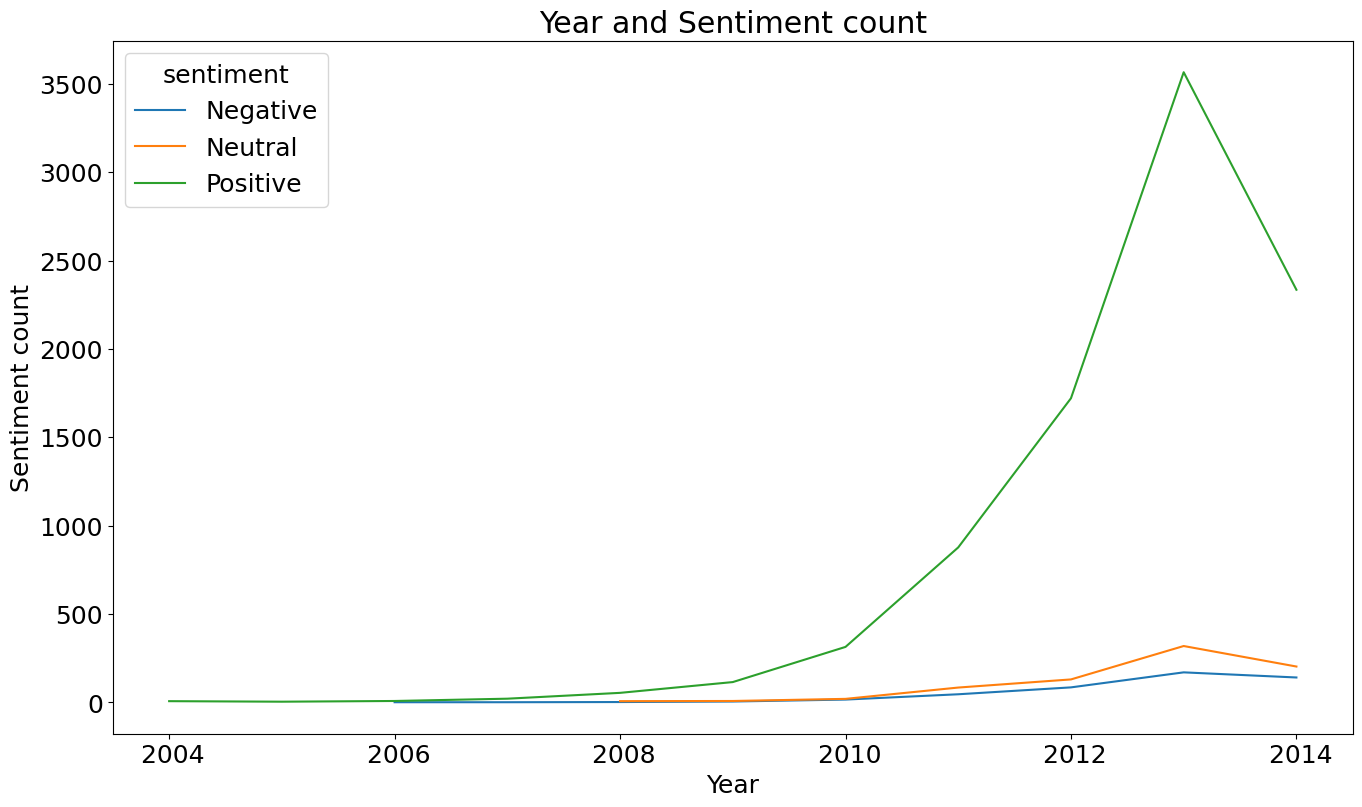

In [26]:
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

**Insights:** <br>
**From the plot we can clearly see the rise in positive reviews from 2010. Reaching its peak around 2013 and there is a dip in 2014, All the review rates were dropped at this time. Negative and neutral reviews are very low as compared to the positive reviews. Our second assumption is wrong !**

## Day of month vs Reviews count
**Let's check if there are any relationship between reviews and day of month**

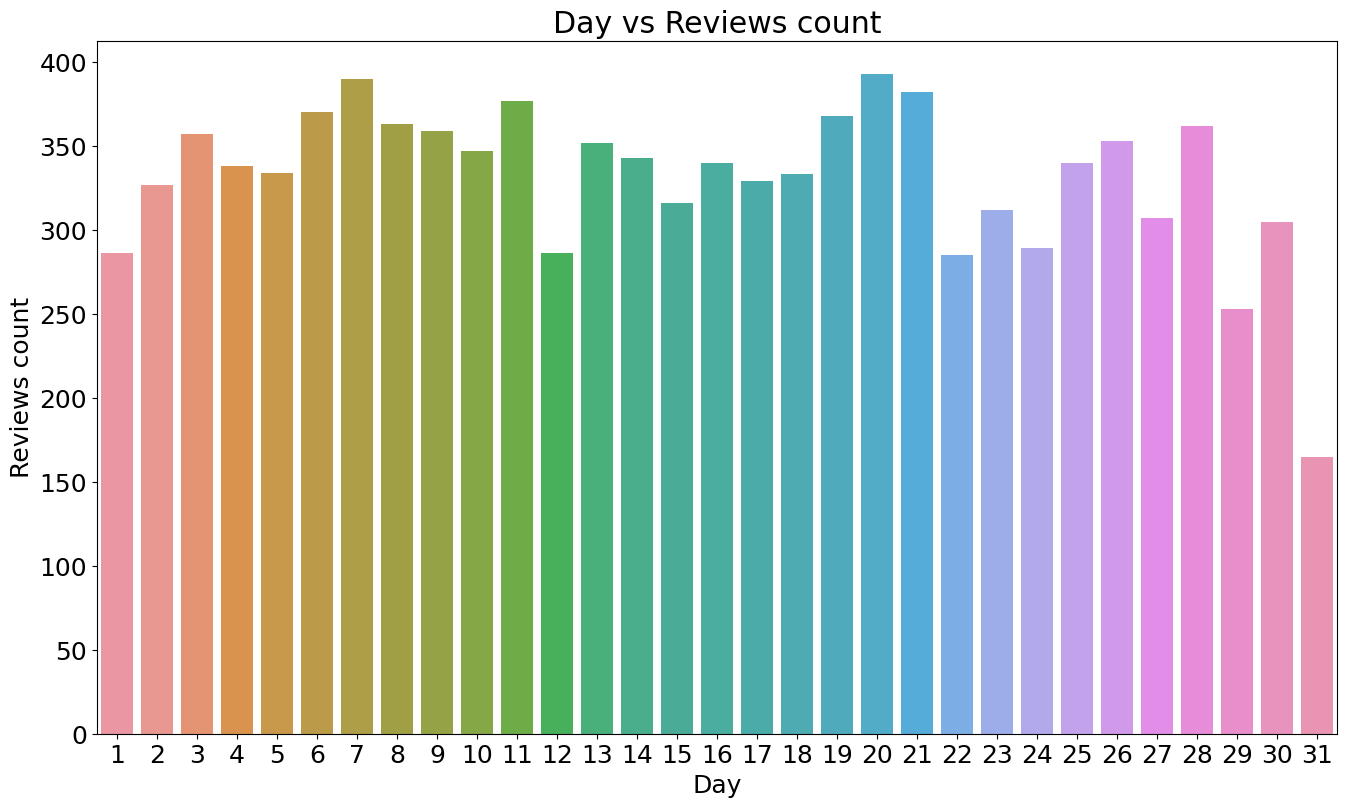

In [27]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

**Insights:** <br>
**The distribution of review counts appears to be relatively uniform across the days of the month, with minimal variance. However, there is a significant decrease observed towards the end of the month. This contradicts our third assumption, highlighting the importance of conducting thorough exploratory data analysis (EDA) rather than relying solely on instincts.**

## Creating few more features for text analysis


In [28]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [29]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  helpful_rate  polarity  review_len  word_count  
0  28          0.00  0.250000         162          25  
1  16          0.93  0.014286         356          55  
2  28          1.00  0.167500         315          48  
3  14          0.00  0.333333         169          22  
4  21          0.00  0.800000         136          21

In [30]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Sentiment polarity distribution


In [31]:
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='Polarity',
    linecolor='black',
    yTitle='Count',
    title='Sentiment Polarity Distribution',
    colors=['purple'])


**Insights:**
* **We have a lot of positive polarities compared to the negative polarities**
* **This polarity distributions assures the number of positive reviews we had**
* **We can say that this polarity is a normally distributed but not standard normal**


## Review Rating Distribution


In [32]:
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='Rating',
    linecolor='black',
    yTitle='Count',
    title='Review Rating Distribution',
    colors=['cyan'])


**We have a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. It's linear in nature **

## Review Text Length Distribution


In [33]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='Review Length',
    linecolor='black',
    yTitle='Count',
    title='Review Text Length Distribution',
    colors=['red'])


**We have a right skewed distribution where most of the lengths falls between 0-1000**

## Review Text Word Count Distribution


In [34]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='Word Count',
    linecolor='black',
    yTitle='Count',
    title='Review Text Word Count Distribution',
    colors=['yellow'])


**We have a right skewed distribution with most of the words falling between 0-200 in a a review** 

## N-gram analysis


## Monogram / Unibram  analysis
**Here we will plot most frequent **one word in reviews** based on sentiments**

In [35]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

**As we see, the words doen't match with the sentiment except few. Through monogram we can't judge a sendiment based on one word. So let's try with frequent two words**

## Bigram analysis
**Here we will plot most frequent two words in reviews based on sentiments**

In [36]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'pink')  # Change color to pink

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'yellow')  # Change color to yellow

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'orange')  # Change color to orange

# Creating three subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)

fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')


**Here we can get a clear idea about the sentiments from the bi-words**

## Trigram analysis
**Here we will plot most frequent three words in reviews based on sentiments**

In [37]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')


**We have completed our text ngram analysis. Let's look at wordcloud **

## Wordcloud-Positive reviews



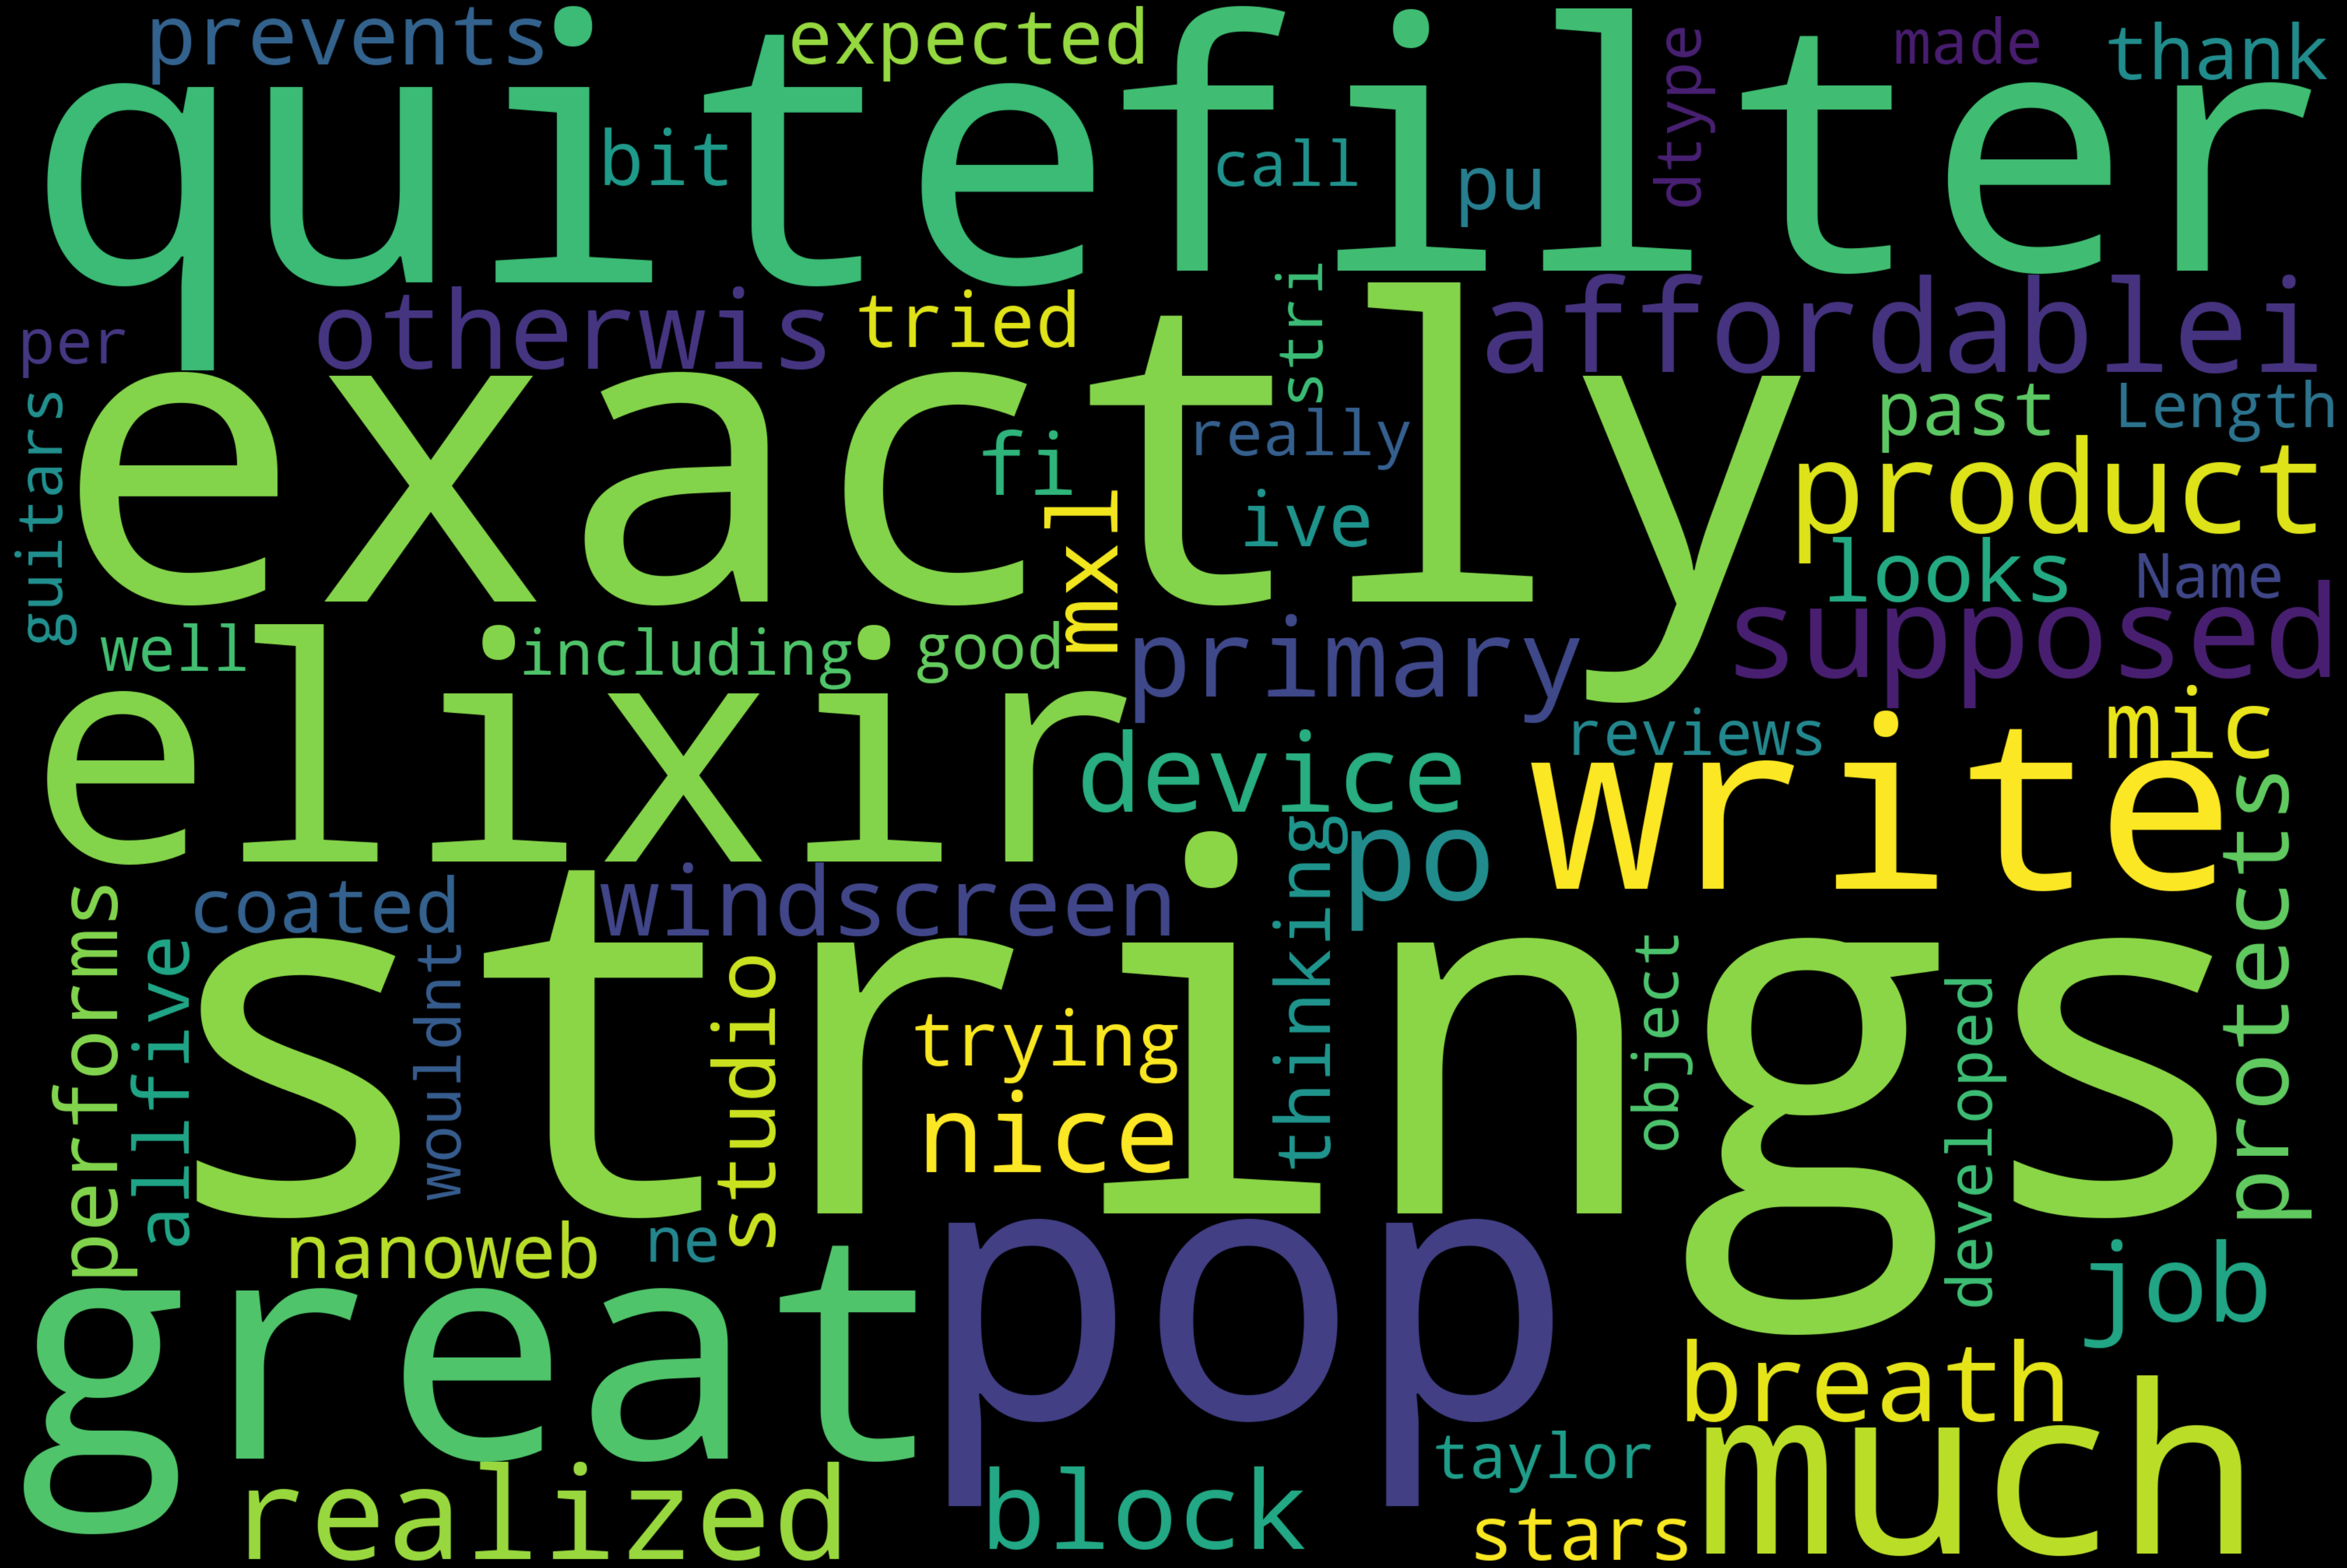

In [38]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**We can see positive words like great,affordable,expected,exactly etc.,**

## Wordcloud-Neutral reviews



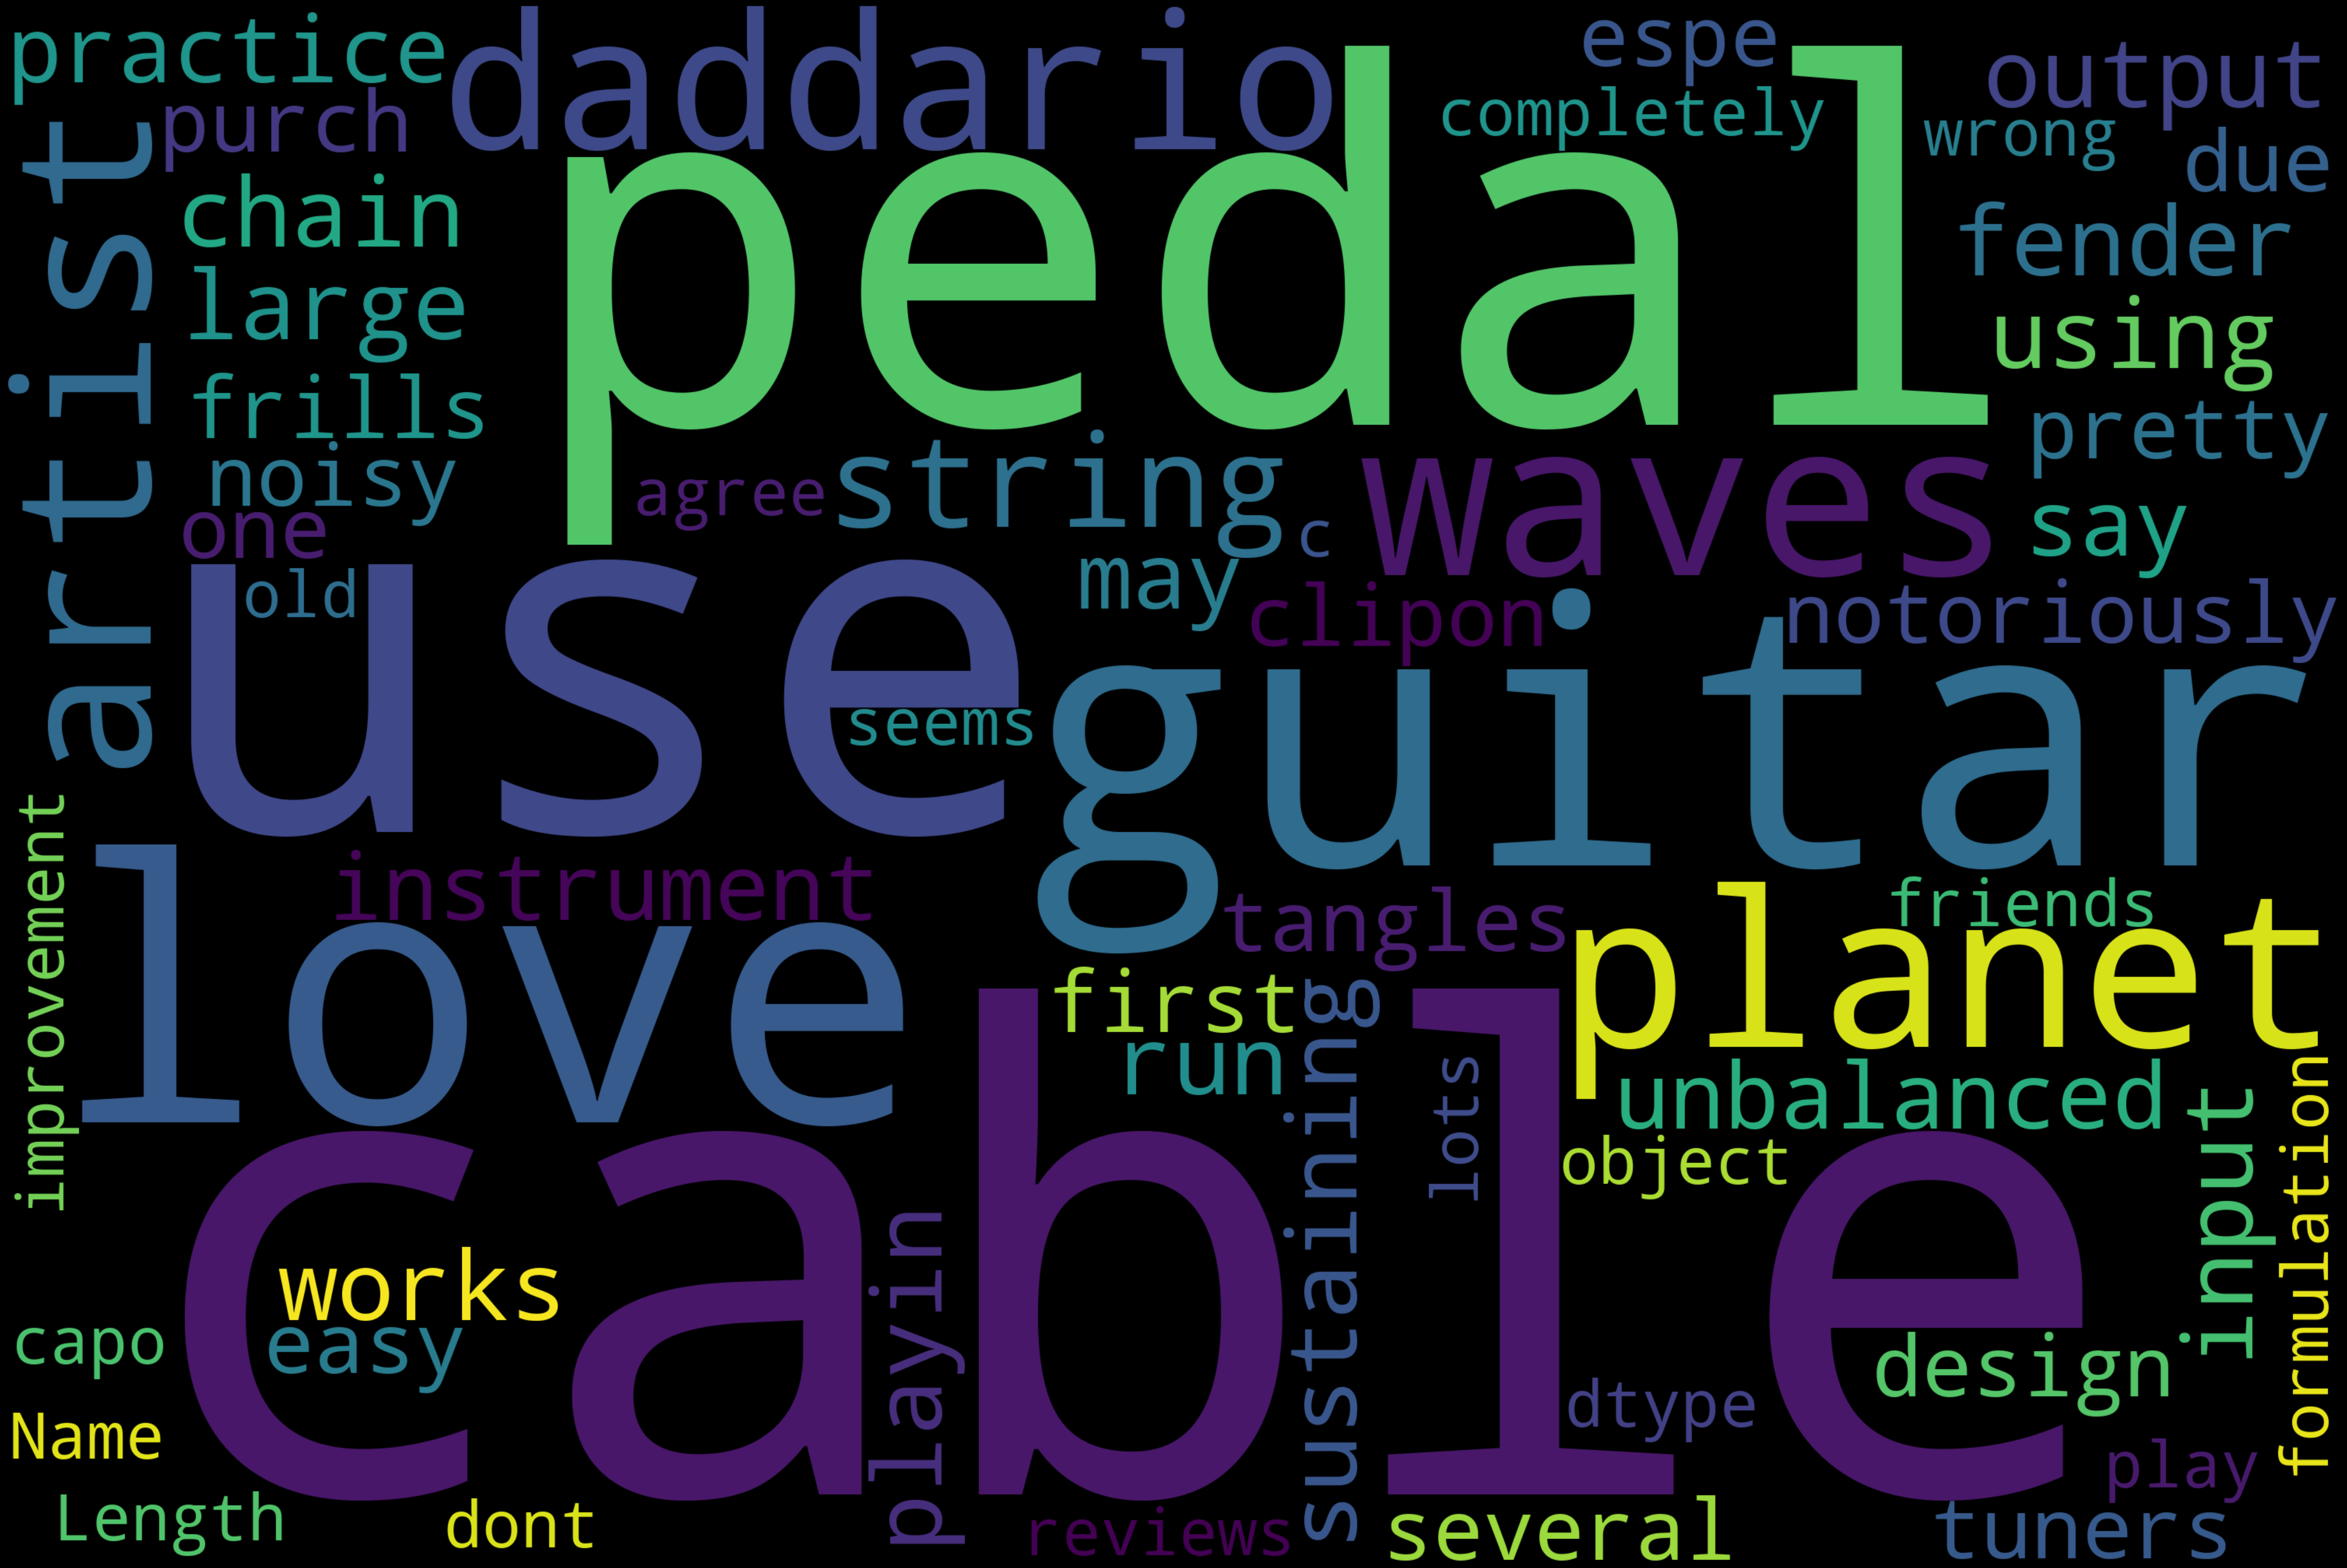

In [39]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Most of the neutral review words are focussed on the products and how can they be improved.**

## Wordcloud-Negative reviews



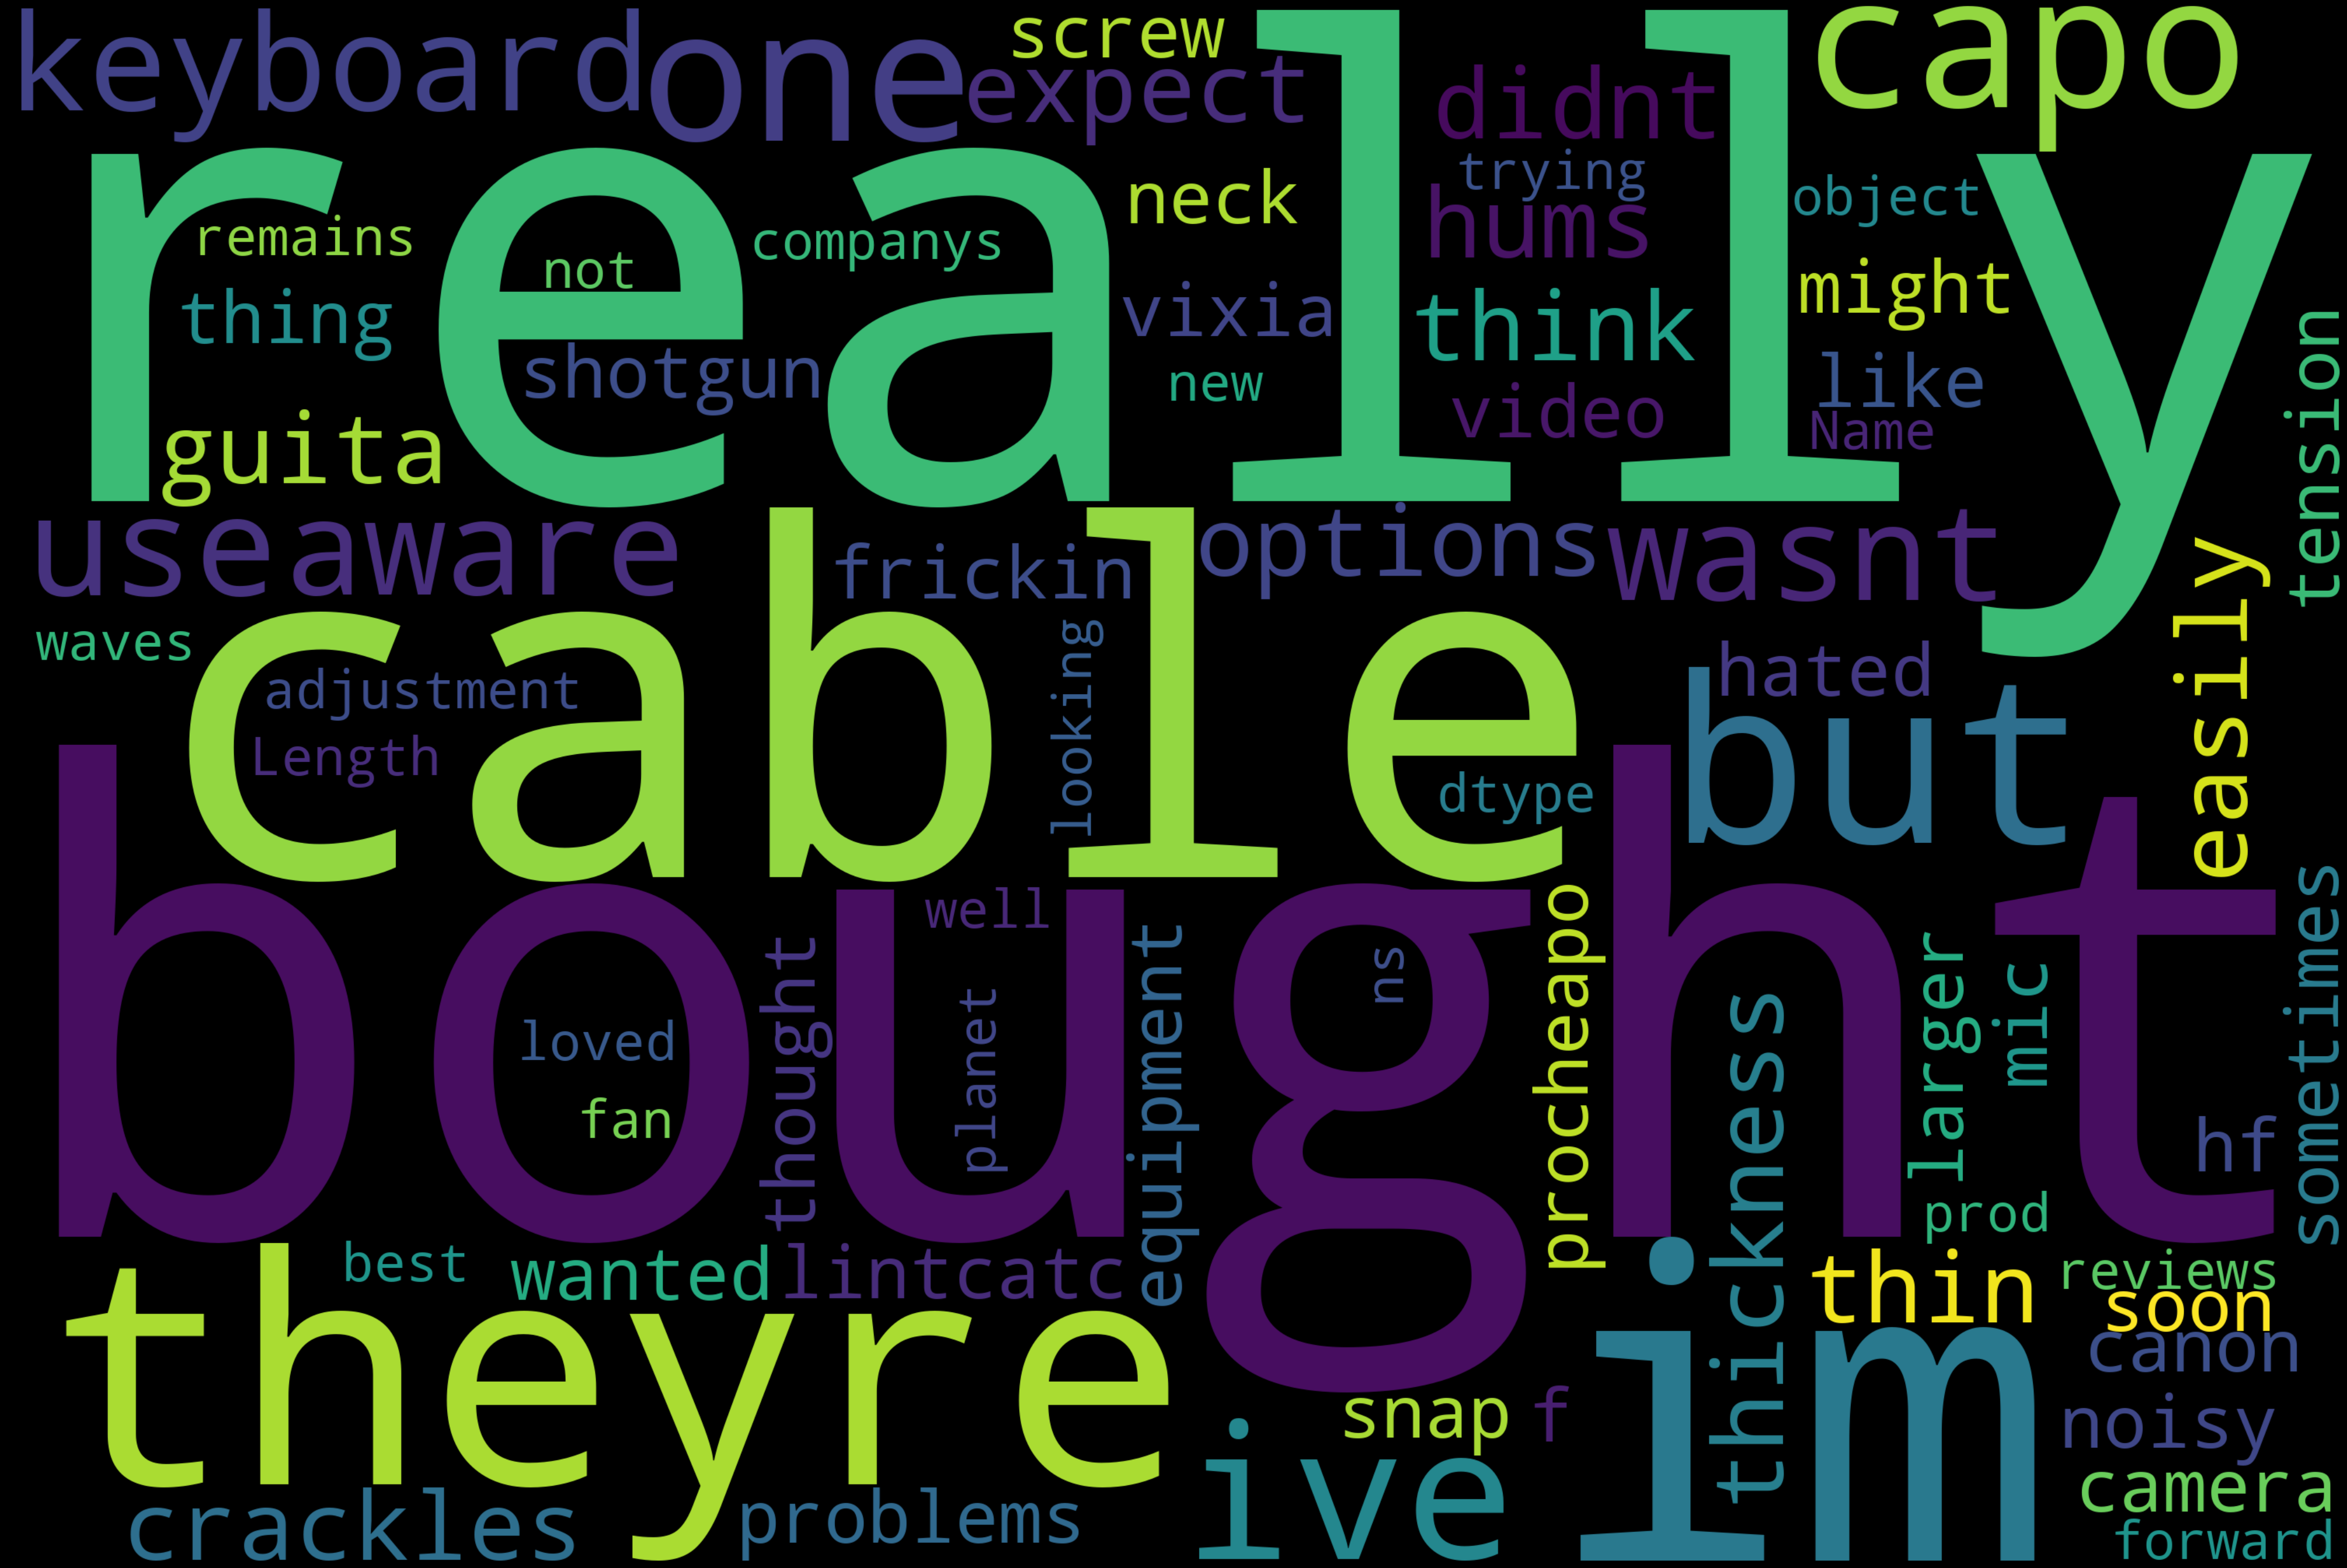

In [40]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**We can see negative review words such as noisy,didnt,frickin,wasnt,snap,problems,tension etc.,**

<a id="section-four"></a>
# Extracting Features from Cleaned reviews


## Encoding target variable-sentiment


In [41]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([2, 1, 0])

In [42]:
process_reviews['sentiment'].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

## Stemming the Reviews

Stemming involves deriving the root word from the inflected word. Here, we extract the reviews and convert the words within the reviews to their root form. For instance:
* **Going** becomes **go**
* **Finally** becomes **fina**

It's worth noting that the root words obtained through stemming may not necessarily retain their semantic meaning. Another technique called Lemmatization is available, which converts words into root forms that do retain semantic meaning. However, due to its time-consuming nature, we're opting for stemming in this scenario.

In [43]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  not much write but exactly supposed filters po...
1  product exactly quite affordablei not realized...
2  primary job device block breath would otherwis...
3  nice windscreen protects mxl mic prevents pops...
4  pop filter great looks performs like studio fi...

In [44]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    

In [45]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

**This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF**

## TFIDF(Term Frequency — Inverse Document Frequency)


**Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.**

In [46]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [47]:
X.shape

(10261, 5000)

**As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.**

In [48]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

## Addressing Imbalanced Target Feature with SMOTE

In our target feature, we've observed a considerable disparity between the number of positive sentiments compared to negative and neutral sentiments. To mitigate this imbalance, we employ SMOTE (Synthetic Minority Oversampling Technique). SMOTE addresses the issue by balancing class distribution through the random generation of synthetic examples for the minority class, thus augmenting its representation in the dataset.

In [49]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


Great, as you can see the resampled data has equally distributed classes

## Train-test split(75:25)


In [50]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

<a id="section-five"></a>
# Model Building: Sentiment Analysis
**As we have successfully processed the text data, not it is just a normal machine learning problem. Where from the sparse matrix we predict the classes in target feature.**

In [51]:
def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if classes is None:
        classes = np.arange(cm.shape[0])
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Model selection



In [52]:
!pip install xgboost

from xgboost import XGBClassifier

# Creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv = DecisionTreeClassifier()
knn_cv = KNeighborsClassifier()
svc_cv = SVC()
nb_cv = BernoulliNB()
xgb_cv = XGBClassifier()  # Add XGBoost classifier
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'KNN', 3: 'SVC', 4: 'Naive Bayes', 5: 'XGBoost'}
cv_models = [logreg_cv, dt_cv, knn_cv, svc_cv, nb_cv, xgb_cv]  # Include XGBoost classifier in the list

for i, model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i], cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()))


Logistic Regression Test Accuracy: 0.8810059200798708
Decision Tree Test Accuracy: 0.8132745311292947
KNN Test Accuracy: 0.8790565074375868
SVC Test Accuracy: 0.8795439317757772
Naive Bayes Test Accuracy: 0.8038184420263036
XGBoost Test Accuracy: 0.8782769701490555


**From the results, we can see logistic regression outdone the rest of the algorithms and all the accuracies from the results are more than 80%. That's great. So let's go with logistic regression with hyperparameter tuning.**

## Logistic Regression with Hyperparameter tuning
**We use regularization parameter and penality for parameter tuning. let's see which one to plug.**

In [53]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9405940594059405


**From the selected params, we get accuracy. Let's plug and chug**

In [54]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


**We have got 94% accuracy. That ain't bad. But for classification problems we need to get confusion matrix and check f1 score rather than accuracy**

## Classification metrics
**Here we plot the confusion matrix with ROC and check our f1 score**

Confusion matrix, without normalization


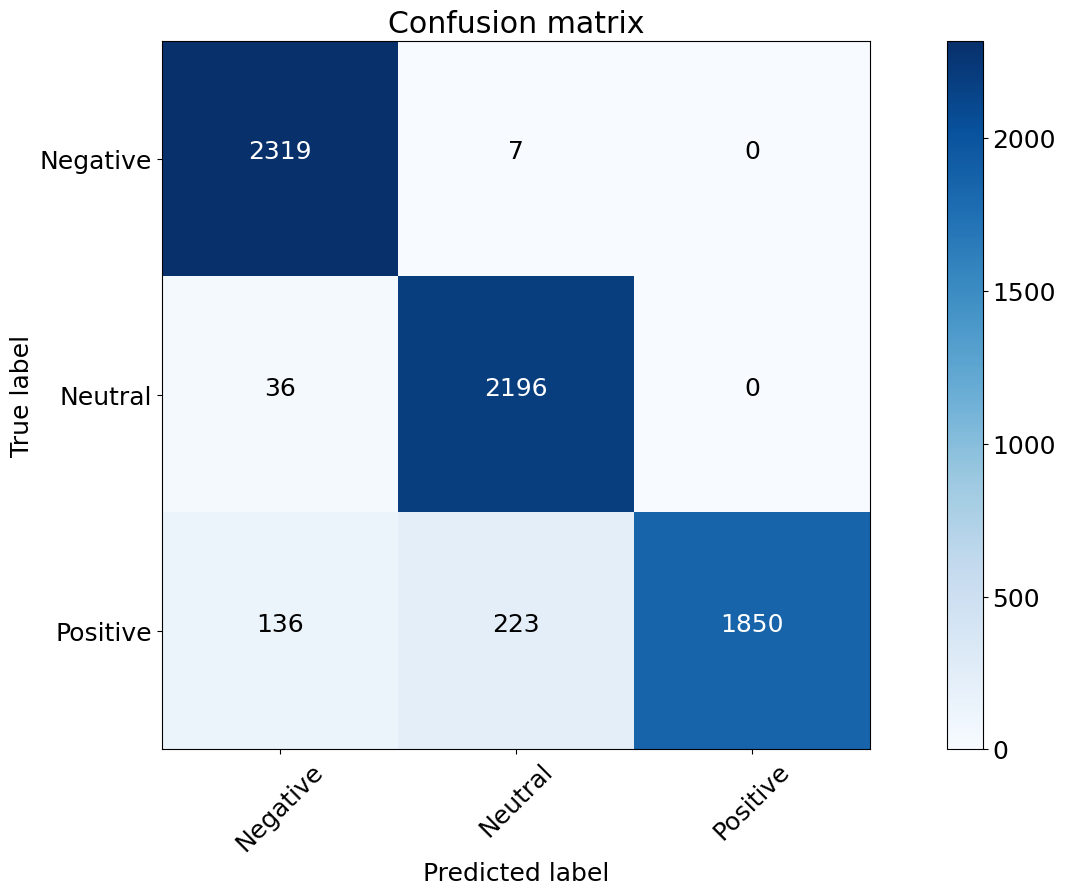

In [55]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative', 'Neutral', 'Positive'])


**Check out the diagonal elements(2326+2195+1854), they are correctly predicted records and rest are incorrectly classified by the algorithm**

In [56]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      2326
           1       0.91      0.98      0.94      2232
           2       1.00      0.84      0.91      2209

    accuracy                           0.94      6767
   macro avg       0.95      0.94      0.94      6767
weighted avg       0.94      0.94      0.94      6767



**Since predicting both positive,negative and neutral reviews are important we are considering.We got a pretty good f1 score. As we see it got a good score across all classes classified **

## ROC-AUC curve
**This is a very important curve where we decide on which threshold to setup based upon the objective criteria. 
Here we plotted ROC for different classes which can help us understand which class was classified better. 
Also we plot micro and macro averages on the roc curve.**

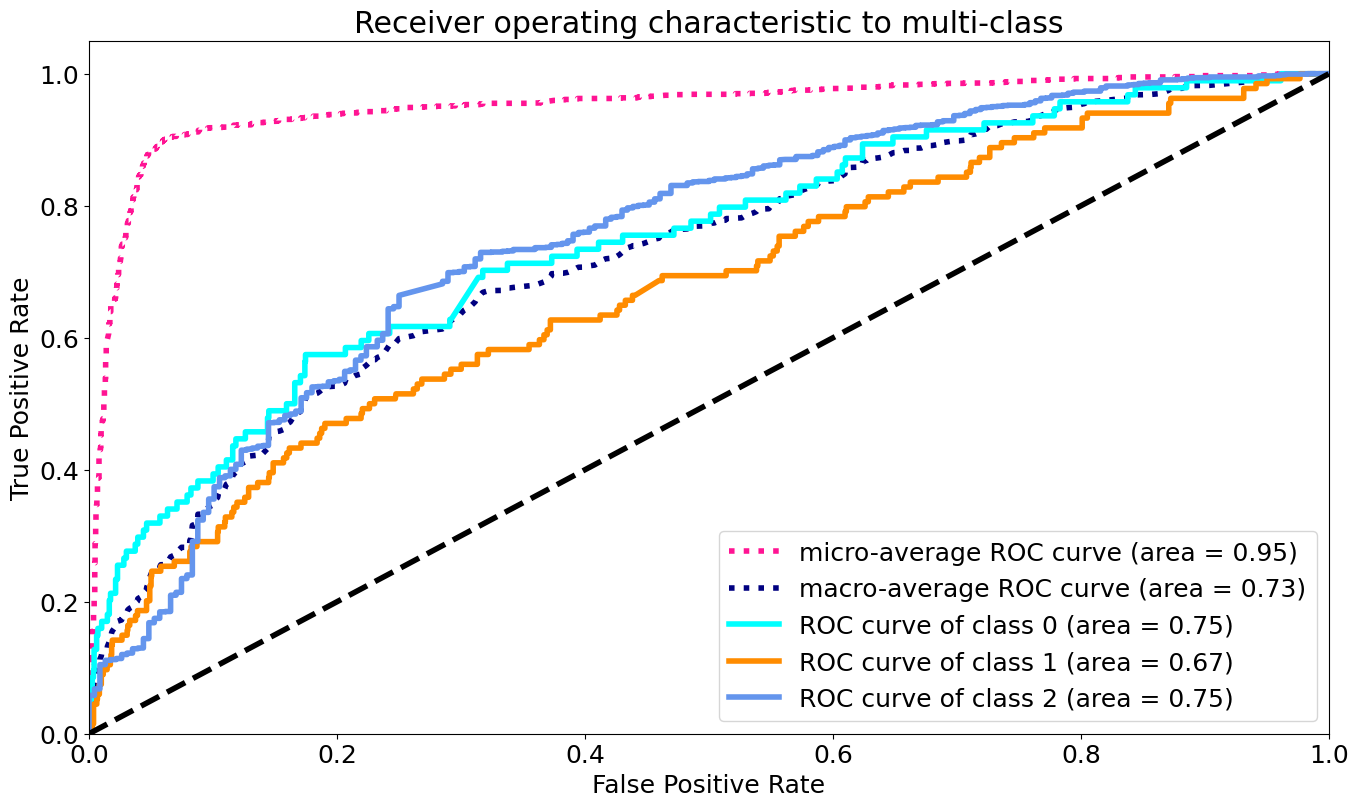

In [57]:
# Binarizing the target feature
y_modified = label_binarize(y, classes=[0, 1, 2])
n_classes_modified = y_modified.shape[1]

# Train-Test split (80:20)
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X, y_modified, test_size=.2, random_state=0)

# OneVsRestClassifier
classifier_modified = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=10))
y_score_modified = classifier_modified.fit(X_train_modified, y_train_modified).decision_function(X_test_modified)

# Computing TPR and FPR
fpr_modified = dict()
tpr_modified = dict()
roc_auc_modified = dict()
for i in range(n_classes_modified):
    fpr_modified[i], tpr_modified[i], _ = roc_curve(y_test_modified[:, i], y_score_modified[:, i])
    roc_auc_modified[i] = auc(fpr_modified[i], tpr_modified[i])

# Compute micro-average ROC curve and ROC area
fpr_modified["micro"], tpr_modified["micro"], _ = roc_curve(y_test_modified.ravel(), y_score_modified.ravel())
roc_auc_modified["micro"] = auc(fpr_modified["micro"], tpr_modified["micro"])

# Aggregate all false positive rates
all_fpr_modified = np.unique(np.concatenate([fpr_modified[i] for i in range(n_classes_modified)]))

# Interpolate all ROC curves at this points
mean_tpr_modified = np.zeros_like(all_fpr_modified)
for i in range(n_classes_modified):
    mean_tpr_modified += interp(all_fpr_modified, fpr_modified[i], tpr_modified[i])

# Finally average it and compute AUC
mean_tpr_modified /= n_classes_modified

fpr_modified["macro"] = all_fpr_modified
tpr_modified["macro"] = mean_tpr_modified
roc_auc_modified["macro"] = auc(fpr_modified["macro"], tpr_modified["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr_modified["micro"], tpr_modified["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_modified["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_modified["macro"], tpr_modified["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_modified["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors_modified = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes_modified), colors_modified):
    plt.plot(fpr_modified[i], tpr_modified[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_modified[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


**Insights:**
* **Upon examining the ROC curve for different classes, it's evident that classes 2 and 0 have been effectively classified, as indicated by their high area under the curve. Optimal trade-offs between True Positive Rate (TPR) and False Positive Rate (FPR) can be achieved by selecting a threshold between 0.6 to 0.8.**
* **In terms of micro and macro averages, the micro-average demonstrates superior performance compared to the macro-average, which exhibits relatively lower scores.**
* **To clarify the distinction between micro and macro averages: A macro-average computes the metric independently for each class and then takes the average, treating all classes equally. Conversely, a micro-average aggregates the contributions of all classes to compute the average metric. In scenarios involving multi-class classification setups, the micro-average is preferable when class imbalance is suspected.**

# Conclusion

* **It's advisable to incorporate n-grams in sentiment analysis to capture more nuanced meaning, as single words may not provide accurate results. Additionally, careful consideration of stop words is crucial, as they may contain negative terms. Hence, avoiding the use of stop words can enhance sentiment analysis accuracy.**
* **Many neutral reviews in our dataset were constructive critiques from buyers, suggesting that Amazon could utilize this feedback to assist sellers in improving their products.**
* **The majority of reviews in this dataset pertained to string instruments, particularly guitars.**
* **Balancing the dataset significantly improved accuracy. Without balancing, precision was reasonable, but recall suffered, adversely impacting the F1 score. Thus, balancing the target feature is imperative.**
* **In sentiment analysis, emphasis should be placed on the F1 score, which achieved an average of 94%, indicating satisfactory performance overall.**